In [1]:
from chordextractor import ChordExtractor
import chordgraph

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy.stats import itemfreq
import time
import os
import pickle
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import Lasso
%matplotlib inline 

## Functions to get vectors from MIDI files for chords, pitches and durations

In [2]:
# Get file names of type type_ in all the subdirectories of the path
def get_filenames(path, type_ = None):
    if type_ == None:
        return sum(map(lambda walks: (map(lambda name: os.path.join(walks[0], name),
                                                                           walks[2])), os.walk(path)), [])
    else:
        return filter(lambda f: f.endswith(type_), sum(map(lambda walks: (map(lambda name: os.path.join(walks[0], name),
                                                                           walks[2])), os.walk(path)), []))
       
# Getting set of all possible chords after normalization        
chord_encode =  {k: i for k, i in zip(chordgraph.ChordGraph().normalized_chords,
                                      range(len(chordgraph.ChordGraph().normalized_chords)))}        
        
# Enumerating chords for processing and storage optimization
def encode_chords(chords, encoder = None, type_ = None):
    if type_ == 'chord':
        return map(lambda chord: encoder[chord], chords)
    return chords

# Generate all sequences of 4 consecutive notes
def get_sequences(data):
    #for seq in imap(lambda i: [data[i], data[i+1], data[i+2], data[i+3]], range(0, len(data)-3)):
    #    yield seq
    return map(lambda i: [data[i], data[i+1], data[i+2], data[i+3]], range(0, len(data)-3))

# Returns index of the note quartet in the vector
def notestoindex(numbers, num):
    return reduce(lambda x, y: num*x+y, numbers)

# Build vector of ocurrences of note quartets
def build_vector(sequence, num):
    vector = [0] * num**4
    seqs_indexed = map(notestoindex, sequence, [num]*len(sequence))
    for x in itemfreq(seqs_indexed):
        vector[x[0]] = x[1]
    return vector

def vector_from_file(filename_):
    extractor = ChordExtractor(filename_)
    chord_vector = build_vector(get_sequences(encode_chords(extractor.getNormalizedChords(), chord_encode, 'chord')),14)
    pitch_vector = build_vector(get_sequences(encode_chords(extractor.getNormalizedPitches())),12)
    return chord_vector, pitch_vector

#normalizedChords = extractor.getNormalizedChords()
#normalizedPitches = extractor.getNormalizedPitches()
# normalizedDurations = extractor.getChordDurations()

# Build vectors from MIDI files and pickle them
def vectors_from_files(path, class_, count):
    files = map(lambda x: x[0], sorted(map(lambda f: [f, os.stat(f).st_size], get_filenames(path)), 
                                   key = lambda x: x[1]))[:count]
    c = 0
    for name in files:
        try: 
            with open(str(class_)+str(c)+".dat", "wb") as f:
                pickle.dump(vector_from_file(name), f)
                print name+" done"
                print str(class_)+str(c)+".dat"
                c+=1
        except:
            print "Couldn't process " + name + " because Music 21 encountered an error."
    #X = map(lambda name: vector_from_file(name), files)
    return True

# Loading vectors from pickles
def get_vectors_from_pickles(path):
    class0 = filter(lambda x: x.split('/')[-1][0]=='0', get_filenames(path, ".dat"))
    class1 = filter(lambda x: x.split('/')[-1][0]=='1', get_filenames(path, ".dat"))
    vector0 = []
    vector1 = []
    for name in class0:
        with open(name, "rb") as f:
            vector0.append(pickle.load(f))
    for name in class1:
        with open(name, "rb") as f:
            vector1.append(pickle.load(f))
    return vector0, vector1

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Rename files, get vectors

In [3]:
# path_to_class0 = './extra/'
# path_to_class1 = './60s/'
# # Renaming 50s and 60s .kar to .mid
# map1 = map(lambda name: os.rename(name, name.replace(".kar", ".mid").replace(".KAR", ".mid")), 
#            get_filenames(path_to_class0))
# map2 = map(lambda name: os.rename(name, name.replace(".kar", ".mid").replace(".KAR", ".mid")), 
#            get_filenames(path_to_class1))

# # Identifying the smallest directory in terms of number of midis
# midi_count = min(len(get_filenames(path_to_class0)), len(get_filenames(path_to_class1)))
# midi_count

In [4]:
# start_time = time.time()
# vectors = vectors_from_files(path_to_class0, 3, 72)
# print "Class 3 is done"
# print("--- %s seconds ---" % (time.time() - start_time))
# vectors2 = vectors_from_files(path_to_class1, 2, 76)
# print "Class 2 is done"
# print("--- %s seconds ---" % (time.time() - start_time))

In [5]:
# extractor = ChordExtractor(fileName="albeniz.mid")
# normalizedChords = extractor.getNormalizedChords()
# normalizedPitches = extractor.getNormalizedPitches()
# normalizedDurations = extractor.getChordDurations()
# type(normalizedDurations)

In [6]:
# Separating chords and pitches, mixing classes so they are spread evenly in the sample set
vector0, vector1 = get_vectors_from_pickles('vectors')
chordvector0 = map(lambda x: x[0], vector0)
chordvector1 = map(lambda x: x[0], vector1)
pitchvector0 = map(lambda x: x[1], vector0)
pitchvector1 = map(lambda x: x[1], vector1)
X_chord = chordvector0+chordvector1
X_pitch = pitchvector0+pitchvector1
Y = [0]*72+[1]*72
X_chord = sum(map(lambda x: [X_chord[x], X_chord[x+72]], range(len(X_chord)/2)), [])
X_pitch = sum(map(lambda x: [X_pitch[x], X_pitch[x+72]], range(len(X_pitch)/2)), [])
Y = sum(map(lambda y: [Y[y], Y[y+72]], range(len(Y)/2)), [])

In [7]:
def rotate(list_, count):
    return sum([list_[-count:]]+[list_[:-count]], [])

In [8]:
# Fitting the parameter C for the SVM model on the training / validation
# Function to train SVM on training set and to predict the validation set
def trainpredict(degree, C):
    clf = svm.SVC(kernel = 'rbf', degree = degree, C = C) 
    clf.fit(X_train, Y_train)
    return (Y_valid == clf.predict(X_valid)).sum()*100/len(Y_valid), degree, C

# Function to fit poly SVMs of degrees 1 to 4 each with Cs from the list
def fitDegree_C():
    return map(lambda degree: map(trainpredict, [degree]*len(np.linspace(-1, 2*degree, 70)),
                            map(lambda c: math.exp(c), np.linspace(-1, 2*degree, 70))), range(3, 4)) 

# SVM

## Chords

In [9]:
# Chords
X_chord_ = X_chord
Y_ = Y
Y_predict = []
Y_original = []
best_fits = []
for i in range(10):
    print "Rotation ", i
    test = int(len(X_pitch)*0.1)
    valid = int(len(X_pitch)*0.10)+test
    Y_test = Y_[-test:]
    Y_valid = Y_[-valid:-test]
    Y_train = Y_[:-valid]
    X_test = X_chord_[-test:]
    X_valid = X_chord_[-valid:-test]
    X_train = X_chord_[:-valid]
    fit_ = fitDegree_C()
    flatten = sum(fit_, [])
    best_fit = max(enumerate(flatten), key = lambda x: x[1])
    best_fits.append(best_fit)
    clf = svm.SVC(kernel = 'rbf', degree = best_fit[1][1], C=best_fit[1][-1])
    clf.fit(X_train, Y_train)
    Y_predict.append(clf.predict(X_test))
    Y_original.append(Y_test)
    
    X_chord_ = rotate(X_chord_, int(len(X_chord_)*0.1))
    Y_ = rotate(Y_, int(len(Y_)*0.1))

Rotation  0
Rotation  1
Rotation  2
Rotation  3
Rotation  4
Rotation  5
Rotation  6
Rotation  7
Rotation  8
Rotation  9


In [10]:
Y_predict_chord = np.asarray(sum(map(lambda y: list(y), Y_predict), []))
Y_origin_chord = np.asarray(sum(map(lambda y: list(y), Y_original), []))

In [11]:
# Checkng on the test set
print "We predict the {} percent of test data".format((Y_origin_chord==Y_predict_chord).sum()*100/len(Y_origin_chord))

We predict the 92 percent of test data


In [12]:
best_fits

[(33, (92, 3, 10.462799766856273)),
 (69, (92, 3, 403.4287934927351)),
 (25, (92, 3, 4.64704662802342)),
 (69, (92, 3, 403.4287934927351)),
 (69, (92, 3, 403.4287934927351)),
 (69, (92, 3, 403.4287934927351)),
 (69, (100, 3, 403.4287934927351)),
 (69, (92, 3, 403.4287934927351)),
 (69, (78, 3, 403.4287934927351)),
 (27, (100, 3, 5.692391364380964))]

Confusion matrix, without normalization
[[60 10]
 [ 1 69]]


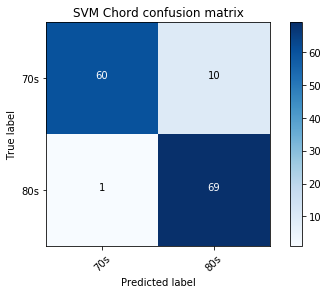

In [13]:
# Confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_origin_chord, Y_predict_chord), classes=['70s', '80s'], normalize=False,
                      title='SVM Chord confusion matrix')

Normalized confusion matrix
[[ 0.85714286  0.14285714]
 [ 0.01428571  0.98571429]]


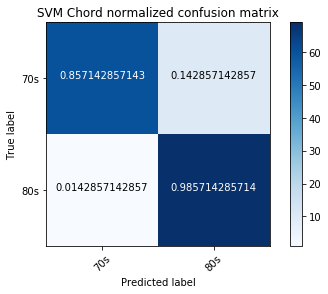

In [14]:
plot_confusion_matrix(confusion_matrix(Y_origin_chord, Y_predict_chord), classes=['70s', '80s'], normalize=True,
                      title='SVM Chord normalized confusion matrix')

# SVM

## Pitches

In [15]:
# Pitches
X_pitch_ = X_pitch
Y_ = Y
Y_predict = []
Y_original = []
best_fits = []
for i in range(10):
    print "Rotation ", i
    test = int(len(X_pitch)*0.1)
    valid = int(len(X_pitch)*0.10)+test
    Y_test = Y_[-test:]
    Y_valid = Y_[-valid:-test]
    Y_train = Y_[:-valid]
    X_test = X_pitch_[-test:]
    X_valid = X_pitch_[-valid:-test]
    X_train = X_pitch_[:-valid]
    fit_ = fitDegree_C()
    flatten = sum(fit_, [])
    best_fit = max(enumerate(flatten), key = lambda x: x[1])
    best_fits.append(best_fit)
    clf = svm.SVC(kernel = 'rbf', degree = best_fit[1][1], C=best_fit[1][-1])
    clf.fit(X_train, Y_train)
    Y_predict.append(clf.predict(X_test))
    Y_original.append(Y_test)
    
    X_pitch_ = rotate(X_pitch_, int(len(X_pitch_)*0.1))
    Y_ = rotate(Y_, int(len(Y_)*0.1))

Rotation  0
Rotation  1
Rotation  2
Rotation  3
Rotation  4
Rotation  5
Rotation  6
Rotation  7
Rotation  8
Rotation  9


In [16]:
Y_predict_pitch = np.asarray(sum(map(lambda y: list(y), Y_predict), []))
Y_origin_pitch = np.asarray(sum(map(lambda y: list(y), Y_original), []))

In [17]:
# Checkng on the test set
print "We predict the {} percent of test data".format((Y_origin_pitch==Y_predict_pitch).sum()*100/len(Y_origin_pitch))

We predict the 97 percent of test data


In [18]:
best_fits

[(69, (100, 3, 403.4287934927351)),
 (69, (100, 3, 403.4287934927351)),
 (69, (100, 3, 403.4287934927351)),
 (69, (92, 3, 403.4287934927351)),
 (69, (100, 3, 403.4287934927351)),
 (69, (100, 3, 403.4287934927351)),
 (69, (100, 3, 403.4287934927351)),
 (69, (100, 3, 403.4287934927351)),
 (69, (85, 3, 403.4287934927351)),
 (7, (100, 3, 0.7483720194325066))]

Confusion matrix, without normalization
[[68  2]
 [ 1 69]]


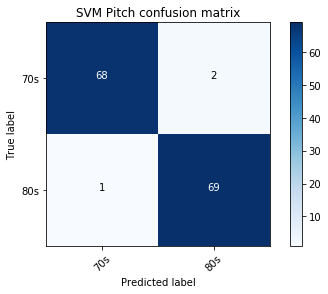

In [19]:
# Confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_origin_pitch, Y_predict_pitch), classes=['70s', '80s'], normalize=False,
                      title='SVM Pitch confusion matrix')

Normalized confusion matrix
[[ 0.97142857  0.02857143]
 [ 0.01428571  0.98571429]]


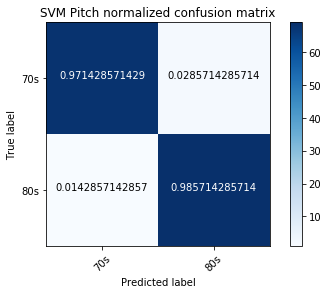

In [20]:
plot_confusion_matrix(confusion_matrix(Y_origin_pitch, Y_predict_pitch), classes=['70s', '80s'], normalize=True,
                      title='SVM Pitch normalized confusion matrix')

# LASSO

## Chords

In [35]:
# Fitting the parameter alpha for the LASSO model on the training / validation
# Function to train LASSO on training set and to predict the validation set
def trainpredict_L(alpha):
    lassoreg = Lasso(alpha = alpha, normalize = False, max_iter = 1e5)
    lassoreg.fit(X_train, Y_train)
    Y_predict = np.round(lassoreg.predict(X_valid))
    return (Y_valid == Y_predict).sum()*100/len(Y_valid), alpha

# Function to fit alpha for LASSO
def fitalpha():
    return map(lambda alpha: trainpredict_L(alpha), np.linspace(0, 2, 100))

def normalize(predictions):
    def positive(prediction):
        if prediction<0:
            return 0
        if prediction>1:
            return 1
        return prediction
    return np.asarray(map(positive, predictions))

# Fitting the alpha
#fitted = fitalpha()

In [22]:
# Chords
X_chord_ = X_chord
Y_ = Y
Y_predict = []
Y_original = []
best_fits = []
for i in range(10):
    print "Rotation ", i
    test = int(len(X_pitch)*0.1)
    valid = int(len(X_pitch)*0.10)+test
    Y_test = Y_[-test:]
    Y_valid = Y_[-valid:-test]
    Y_train = Y_[:-valid]
    X_test = X_chord_[-test:]
    X_valid = X_chord_[-valid:-test]
    X_train = X_chord_[:-valid]
    fit_ = fitalpha()
    best_fit = max(enumerate(fit_), key = lambda x: x[1])
    best_fits.append(best_fit)
    lassoreg = Lasso(alpha = best_fit[1][-1], normalize = False, max_iter = 1e5)
    lassoreg.fit(X_train, Y_train)
    Y_predict.append(np.round(lassoreg.predict(X_valid)))
    Y_original.append(Y_test)
    
    X_chord_ = rotate(X_chord_, int(len(X_chord_)*0.1))
    Y_ = rotate(Y_, int(len(Y_)*0.1))

Rotation  0


/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/home/denis/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


Rotation  1
Rotation  2
Rotation  3
Rotation  4
Rotation  5


/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


Rotation  6
Rotation  7
Rotation  8
Rotation  9


In [23]:
# Looking for the optimal parameters
#max(enumerate(fitted), key = lambda x: x[1])
Y_predict_chord = np.asarray(normalize(sum(map(lambda y: list(y), Y_predict), [])))
Y_origin_chord = np.asarray(sum(map(lambda y: list(y), Y_original), []))

In [24]:
# Checkng on the test set
print "We predict the {} percent of test data".format((Y_origin_chord==Y_predict_chord).sum()*100/len(Y_origin_chord))

We predict the 94 percent of test data


In [25]:
best_fits

[(3, (100, 0.060606060606060608)),
 (3, (100, 0.060606060606060608)),
 (1, (92, 0.020202020202020204)),
 (1, (92, 0.020202020202020204)),
 (3, (92, 0.060606060606060608)),
 (0, (100, 0.0)),
 (2, (92, 0.040404040404040407)),
 (0, (100, 0.0)),
 (17, (92, 0.34343434343434348)),
 (5, (71, 0.10101010101010102))]

Confusion matrix, without normalization
[[63  7]
 [ 1 69]]


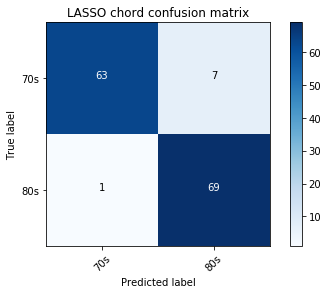

In [26]:
# Confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_origin_chord, Y_predict_chord), classes=['70s', '80s'], normalize=False,
                      title='LASSO chord confusion matrix')

Normalized confusion matrix
[[ 0.9         0.1       ]
 [ 0.01428571  0.98571429]]


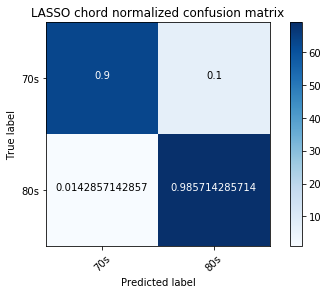

In [27]:
plot_confusion_matrix(confusion_matrix(Y_origin_chord, Y_predict_chord), classes=['70s', '80s'], normalize=True,
                      title='LASSO chord normalized confusion matrix')

# Linear Regression LASSO

## Pithces

In [28]:
# Chords
X_pitch_ = X_pitch
Y_ = Y
Y_predict = []
Y_original = []
best_fits = []
for i in range(10):
    print "Rotation ", i
    test = int(len(X_pitch)*0.1)
    valid = int(len(X_pitch)*0.10)+test
    Y_test = Y_[-test:]
    Y_valid = Y_[-valid:-test]
    Y_train = Y_[:-valid]
    X_test = X_pitch_[-test:]
    X_valid = X_pitch_[-valid:-test]
    X_train = X_pitch_[:-valid]
    fit_ = fitalpha()
    best_fit = max(enumerate(fit_), key = lambda x: x[1])
    best_fits.append(best_fit)
    lassoreg = Lasso(alpha = best_fit[1][-1], normalize = False, max_iter = 1e5)
    lassoreg.fit(X_train, Y_train)
    Y_predict.append(np.round(lassoreg.predict(X_valid)))
    Y_original.append(Y_test)
    
    X_pitch_ = rotate(X_chord_, int(len(X_pitch_)*0.1))
    Y_ = rotate(Y_, int(len(Y_)*0.1))

Rotation  0

/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator



Rotation  1
Rotation  2
Rotation  3
Rotation  4
Rotation  5
Rotation  6
Rotation  7
Rotation  8
Rotation  9


In [36]:
Y_predict_pitch = np.asarray(normalize(sum(map(lambda y: list(y), Y_predict), [])))
Y_origin_pitch = np.asarray(sum(map(lambda y: list(y), Y_original), []))

In [37]:
# Checkng on the test set
print "We predict the {} percent of test data".format((Y_origin_pitch==Y_predict_pitch).sum()*100/len(Y_origin_pitch))

We predict the 97 percent of test data


In [38]:
best_fits

[(8, (78, 0.16161616161616163)),
 (3, (100, 0.060606060606060608)),
 (3, (100, 0.060606060606060608)),
 (3, (100, 0.060606060606060608)),
 (3, (100, 0.060606060606060608)),
 (3, (100, 0.060606060606060608)),
 (3, (100, 0.060606060606060608)),
 (3, (100, 0.060606060606060608)),
 (3, (100, 0.060606060606060608)),
 (3, (100, 0.060606060606060608))]

Confusion matrix, without normalization
[[67  3]
 [ 0 70]]


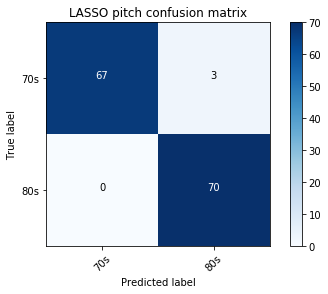

In [39]:
# Confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_origin_pitch, Y_predict_pitch), classes=['70s', '80s'], normalize=False,
                      title='LASSO pitch confusion matrix')

Normalized confusion matrix
[[ 0.95714286  0.04285714]
 [ 0.          1.        ]]


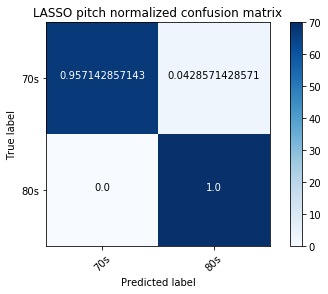

In [40]:
plot_confusion_matrix(confusion_matrix(Y_origin_pitch, Y_predict_pitch), classes=['70s', '80s'], normalize=True,
                      title='LASSO pitch normalized confusion matrix')